In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from classes.Accuracy import Accuracy
from classes.ModelBuilder import ModelBuilder
modelBuilder = ModelBuilder()

C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict
C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\nltk\lm\vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Counter, Iterable


In [2]:
def add_mock_data(df, category, multiplier=10):    
    mask = (df['Intencion_cat_label'] == category)
    row = df[mask]
    return df.append([row]*multiplier,ignore_index=True)

def apply_resample(df, column, num_cases=5, multiplier=10):
    print('-----------------')
    print('Before Resample: ')
    print('-----------------')
    print('Train Shape: ' + str(df.shape))
    
    #add another row to minority class with few values
    grouped = df.groupby('Intencion_cat_label').count().sort_values(by='Intencion_cat_label', ascending=True)
    poor_cases = grouped[grouped[column] < num_cases]
    print('Poor cases: {}'.format(len(poor_cases)))
    print(poor_cases)
    for index in poor_cases.index.unique():
        df = add_mock_data(df, index, multiplier)

    print('----------------')
    print('After Resample: ')
    print('----------------')
    print('Train Shape: ' + str(df.shape))
    return df

C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
columns = ['Pregunta', 'Intencion']
df_train = shuffle(pd.read_csv('data/train.csv', usecols=columns, sep='|'))
df_train['Intencion_cat_label'] = df_train['Intencion'].str[4:]
df_train['Intencion_cat_label'] = df_train['Intencion_cat_label'].astype('int32')
# add one more sample because I have one case with just one sample and stratify need at least 2 samples
df_train = apply_resample(df_train, 'Pregunta', 2, 1)

-----------------
Before Resample: 
-----------------
Train Shape: (20104, 3)
Poor cases: 1
                     Pregunta  Intencion
Intencion_cat_label                     
104                         1          1
----------------
After Resample: 
----------------
Train Shape: (20105, 3)


In [4]:
def plot_occurrences(data, title='Dummy Title'):
    plt.figure(figsize=(35,6))
    sns.countplot(x=data['Intencion_cat_label'], data=data, alpha=0.8, order=data['Intencion_cat_label'].value_counts().index)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('Intencion', fontsize=2)
    plt.xticks(rotation=90)
    plt.title(title, fontsize=20)
    plt.show()

C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


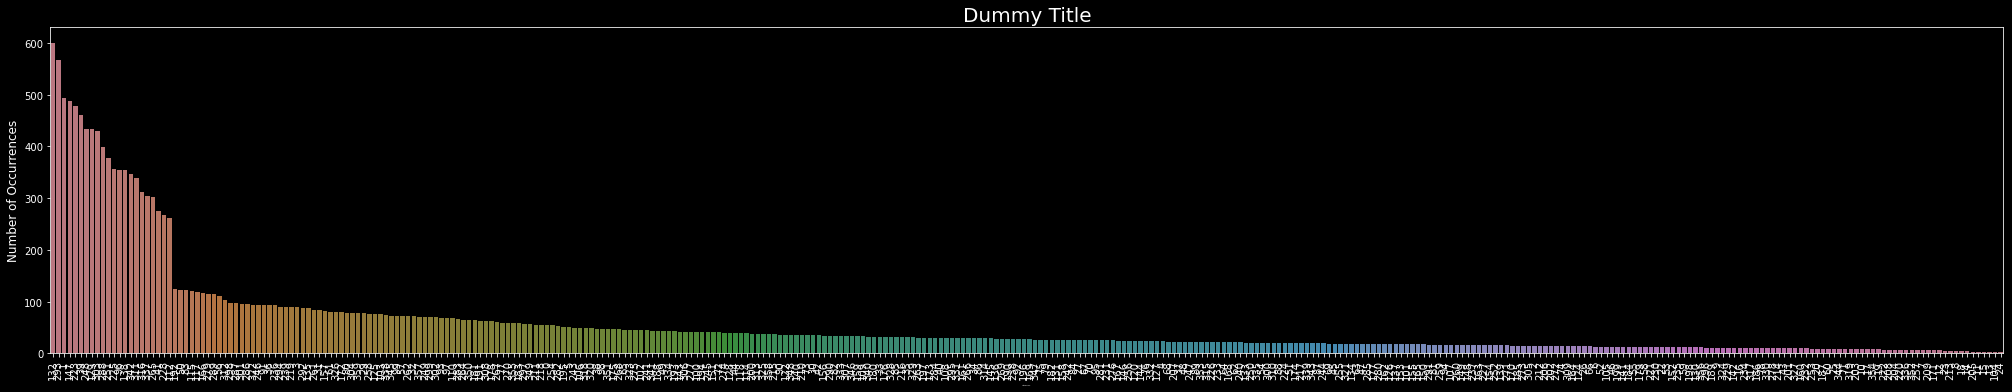

In [5]:
plot_occurrences(df_train)

In [6]:
grouped = df_train.groupby('Intencion_cat_label')['Intencion'].count().sort_values(ascending=True)

C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
major_samples_ids = grouped[(grouped.values < grouped.max()) & (grouped.values > 50)].index.sort_values(ascending=True)
mid_samples_ids = grouped[(grouped.values <= 50) & (grouped.values > 20)].index.sort_values(ascending=True)
low_samples_ids = grouped[(grouped.values <= 20) & (grouped.values > 0)].index.sort_values(ascending=True)

print('Size each group: Major:{}, Mid:{}, Low:{}'.format(len(major_samples_ids), len(mid_samples_ids), len(low_samples_ids)))

Size each group: Major:93, Mid:127, Low:131


In [8]:
def buildModel(classifier, X, y, resampling=False, multiplier=10, train_all_data=False):
    X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, test_size = 0.20, stratify=y)
    y_train = y_train.astype('int')
    y_test = y_test.astype('int')

    if resampling == True:
        #Join X_train and y_train to add more classes to train
        df_Xtrain = pd.DataFrame(X_train, columns=['Pregunta'])
        df_Xtrain.set_index('Pregunta')
        df_Xtrain['Intencion_cat_label'] = y_train
        df_Xtrain.head(3)

        #Apply resample to train dataset
        df_Xtrain = apply_resample(df_Xtrain, 'Pregunta', 50, multiplier)

        X_train = df_Xtrain['Pregunta'].values
        y_train = df_Xtrain['Intencion_cat_label'].values

    with mlflow.start_run():
        mlflow.log_param('Classifier', classifier.__class__.__name__)    
        print('Preprocessing data...')
        vect = modelBuilder.GetVectorizer()
        print('Transforming data...')
        X_train = vect.fit_transform(X_train, y_train)
        
        if resampling == True:
            mlflow.log_param('resampling', resampling)
            from imblearn.over_sampling import SMOTE, RandomOverSampler, SVMSMOTE, ADASYN
            from imblearn.under_sampling import RandomUnderSampler
            sampling_strategy='not majority'    
            k_neighbors = 5
            mlflow.log_param('sampling_strategy', sampling_strategy)
            mlflow.log_param('k_neighbors', k_neighbors)
            oversample = SMOTE(random_state=42, sampling_strategy=sampling_strategy, n_jobs=-1, k_neighbors=k_neighbors)
            print('Resampling data...')
            X_train, y_train = oversample.fit_resample(X_train, y_train)

        print(X_train.shape)
        print('Training Model...')
        classifier.fit(X_train, y_train)
        print('Predict on Test...')
        X_test = vect.transform(X_test)
        pred = classifier.predict(X_test)
        training_score = classifier.score(X_train , y_train)
        test_score = classifier.score(X_test  , y_test )
        mlflow.log_metric('training_score', training_score)
        mlflow.log_metric('test_score', test_score)
        model_name = classifier.__class__.__name__
        print("Training set score for " + model_name + " %f" % training_score)
        print("Testing  set score for " + model_name + " %f" % test_score)
        print('--------------------------------------------------------')      


        #Compute the balanced accuracy
        #The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class.
        #The best value is 1 and the worst value is 0 when adjusted=False.
        balanced_accuracy_score = Accuracy.get_balanced_accuracy_score(y_test, pred)
        accuracy_score = Accuracy.get_accuracy_score(y_test, pred)
        mlflow.log_metric("balanced_accuracy_score", balanced_accuracy_score)
        mlflow.log_metric("accuracy_score", accuracy_score)        
        mlflow.sklearn.log_model(classifier, "model")

        if train_all_data == True:
            X = vect.fit_transform(X, y)
            print('Training Model With all train dataset...')
            classifier.fit(X, y)
            print('Finished Training Model With all train dataset.')
            training_score = classifier.score(X , y)
            print("Training score for all data: %f" % training_score)

        #mlflow.end_run()
        df_Xtrain = pd.DataFrame(X_train, columns=['Pregunta'])
        df_Xtrain.set_index('Pregunta')
        df_Xtrain['Intencion_cat_label'] = y_train

        cnt_pro = df_Xtrain['Intencion_cat_label'].value_counts()

        plt.figure(figsize=(35,4))
        sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
        plt.ylabel('Number of Occurrences', fontsize=12)
        plt.xlabel('Intencion', fontsize=2)
        plt.xticks(rotation=90)
        plt.show()

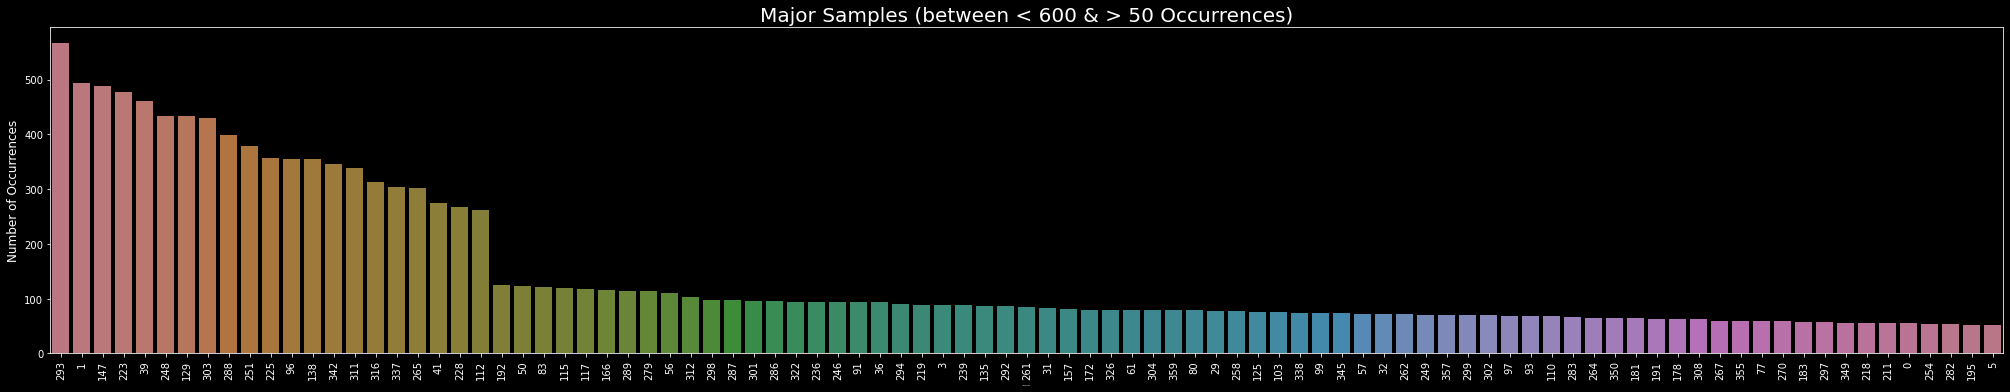

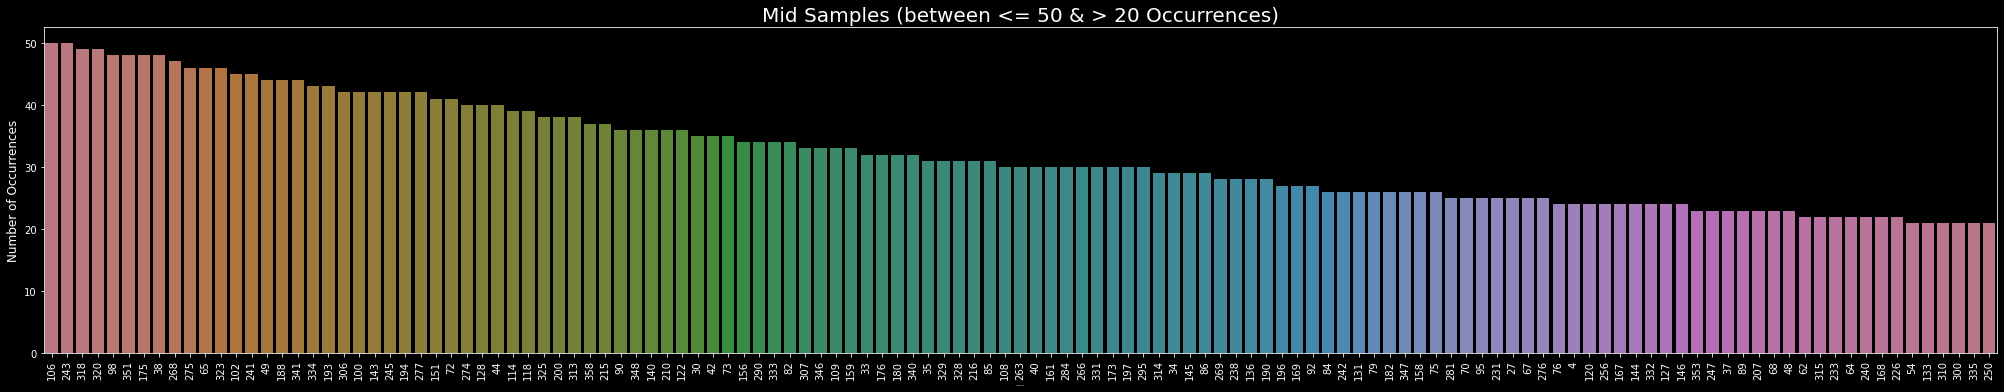

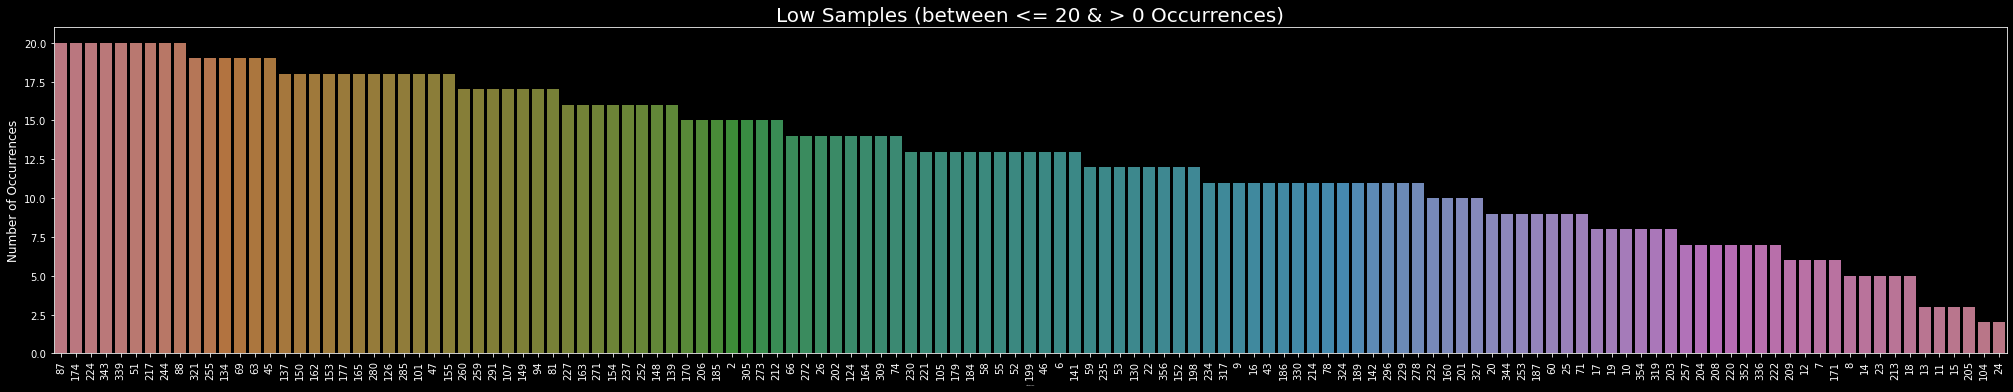

In [9]:
major_samples = df_train[df_train['Intencion_cat_label'].isin(major_samples_ids)]
plot_occurrences(major_samples, 'Major Samples (between < {} & > {} Occurrences)'.format(grouped.max(), 50))
mid_samples = df_train[df_train['Intencion_cat_label'].isin(mid_samples_ids)]
plot_occurrences(mid_samples, 'Mid Samples (between <= 50 & > 20 Occurrences)')
low_samples = df_train[df_train['Intencion_cat_label'].isin(low_samples_ids)]
plot_occurrences(low_samples, 'Low Samples (between <= 20 & > 0 Occurrences)')

df_list = [major_samples, mid_samples, low_samples]

C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Preprocessing data...
Transforming data...
(11008, 4381)
Training Model...
[LibLinear]Predict on Test...
Training set score for LinearSVC 0.988372
Testing  set score for LinearSVC 0.866691
--------------------------------------------------------

--------------------------------------------------------
-- Summary --
--------------------------------------------------------
balanced_accuracy_score: 0.79

--------------------------------------------------------
-- Summary --
--------------------------------------------------------
accuracy_score: 0.87


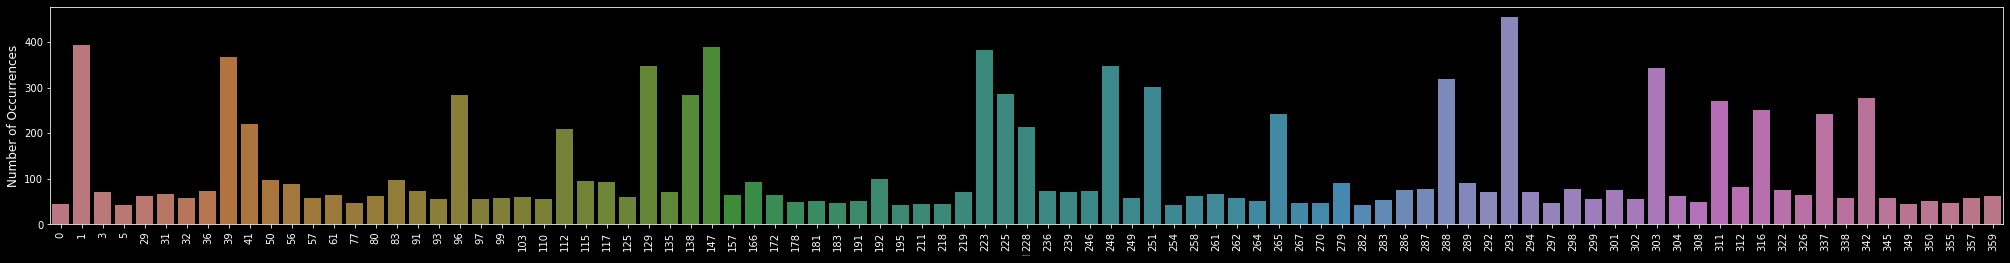

In [10]:
major_samples_classifier = LinearSVC(verbose=2, random_state=42)

X = major_samples['Pregunta'].values
y = major_samples['Intencion_cat_label'].values

buildModel(major_samples_classifier, X, y)

C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Preprocessing data...
Transforming data...
(3270, 2793)
Training Model...
[LibLinear]Predict on Test...
Training set score for LinearSVC 0.999083
Testing  set score for LinearSVC 0.810513
--------------------------------------------------------

--------------------------------------------------------
-- Summary --
--------------------------------------------------------
balanced_accuracy_score: 0.81

--------------------------------------------------------
-- Summary --
--------------------------------------------------------
accuracy_score: 0.81


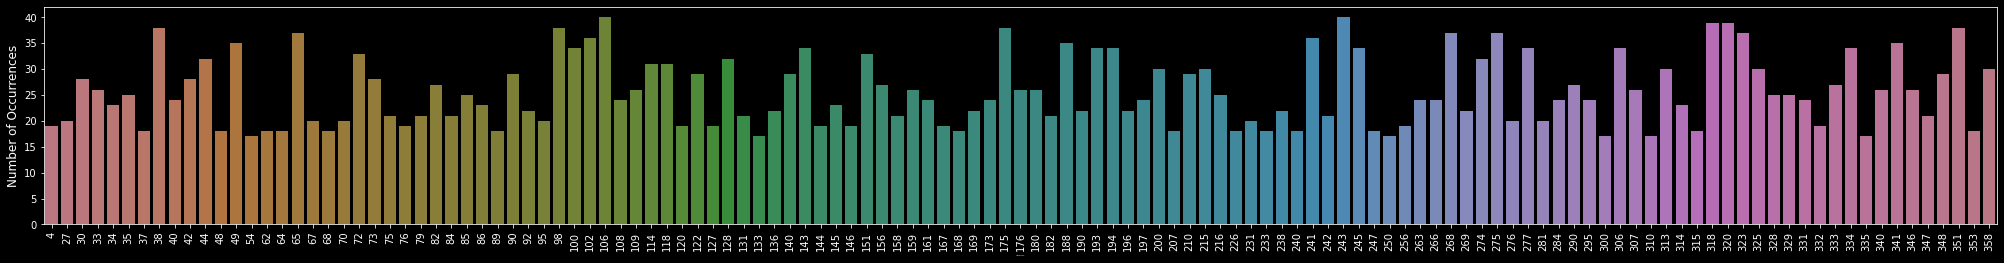

In [11]:
mid_samples_classifier = LinearSVC(verbose=2, random_state=42)

X = mid_samples['Pregunta'].values
y = mid_samples['Intencion_cat_label'].values

buildModel(mid_samples_classifier, X, y)

C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
-----------------
Before Resample: 
-----------------
Train Shape: (1324, 2)
Poor cases: 131
                     Pregunta
Intencion_cat_label          
2                          12
6                          10
7                           5
8                           4
9                           9
...                       ...
343                        16
344                         7
352                         6
354                         6
356                        10

[131 rows x 1 columns]
----------------
After Resample: 
----------------
Train Shape: (14564, 2)
Preprocessing data...
Transforming data...

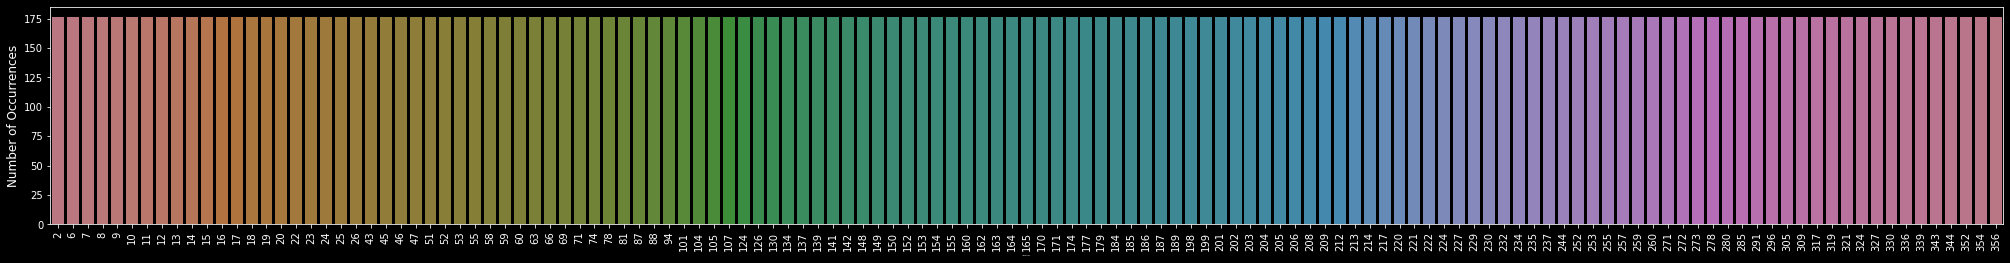

In [12]:
low_samples_classifier = LinearSVC(verbose=2, random_state=42)

X = low_samples['Pregunta'].values
y = low_samples['Intencion_cat_label'].values

buildModel(low_samples_classifier, X, y, resampling= True, multiplier=10)

In [13]:
#--------------------------------------------------#
### TO USE STACKING OR VOTING UNCOMMENT ALL THIS ###
#--------------------------------------------------#
# define the base models
level0 = list()	
level0.append(('lsvc1', LinearSVC(verbose=2, random_state=42)))
level0.append(('lsvc2', LinearSVC(verbose=2, random_state=42)))
level0.append(('lsvc3', LinearSVC(verbose=2, random_state=42)))	
# define meta learner model
level1 = LogisticRegression()
# define the stacking ensemble
stackingclassifier = StackingClassifier(estimators=level0, final_estimator=level1, verbose=2, n_jobs=-1)
#votingClassifier = VotingClassifier(estimators=level0, verbose=2)

C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
X = df_train['Pregunta'].values
y = df_train['Intencion_cat_label'].values
buildModel(stackingclassifier, X, y)

Preprocessing data...
Transforming data...
(16084, 5889)
Training Model...
